In [ ]:
# importing libs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_profiling import ProfileReport

import os

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

random_state=17

from scipy.stats import skew

import seaborn as sns
seq_col_brew = sns.color_palette("RdBu_r", 12)
sns.set_palette(seq_col_brew)

In [ ]:
# opening file

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving insurance.csv to insurance.csv
User uploaded file "insurance.csv" with length 9898 bytes


# Предобработка данных

**1. Перейдите по ссылке в таблице успеваемости, скачайте ваш набор данных, прочитайте его.**

In [ ]:
# reading data

df = pd.read_csv('insurance.csv', delimiter=',')
df.head(120)

age  sex     bmi  children  smoker  region      charges
0     19    0  27.900         0       1       3  16884.92400
1     18    1  33.770         1       0       2   1725.55230
2     28    1  33.000         3       0       2   4449.46200
3     33    1  22.705         0       0       1  21984.47061
4     32    1  28.880         0       0       1   3866.85520
..   ...  ...     ...       ...     ...     ...          ...
115   60    1  28.595         0       0       0  30259.99556
116   58    1  49.060         0       0       2  11381.32540
117   29    0  27.940         1       1       2  19107.77960
118   49    0  27.170         0       0       2   8601.32930
119   37    0  23.370         2       0       1   6686.43130

[120 rows x 7 columns]

**2. Опишите чему посвящен ваш набор данных. Какие задачи могут быть решены с его применением?** 

Датасет содержит информацию о суммах страховых выплат для имеющихся в базе респондентов.

С помощью датасета можно предсказать возможный размер страховых выплат для новых, только поступивших респондентов, основываясь на информации, которая о них известна (возраст, пол, индекс массы тела, наличие детей, курящий/некурящий, регион).

**3. Изучите признаки. Какова целевая переменная? 
Какие признаки, на первый взгляд, будут играть большую роль в задаче, а какие могут оказаться менее релевантными? 
Получите дескриптивные характеристики набора данных.**
Целевой переменной является charges (размер страховых выплат). В данном случае трудно сказать, что какие-то признаки будут наиболее значимыми в предсказывании charges, поскольку на формирование выплат в равной степени могут влиять как возраст и регион проживания (уровень экологии влияет на вероятность заболеваний), так и индекс массы тела и курение. 

Дескриптивные характеристики получены.

Сюда входят общее число экземпляров (строк), среднее, стандартное отклонение, минимальное значение, первый квартиль, мода, третий квартиль, максимальное значение.
Из них можно узнать, что, например, параметр std (стандартное отклонение) наибольший для признаков charges. Это говорит о высокой изменчивости величины.
Или, например, что в датасете представлена информация о респондентах в возпасте от 18 до 64 лет.

In [ ]:
# describing data

statistics = df.describe()
statistics

age         sex         bmi  ...      smoker      region       charges
count  348.000000  348.000000  348.000000  ...  348.000000  348.000000    348.000000
mean    39.591954    0.508621   30.676552  ...    0.232759    1.497126  14016.426293
std     14.417015    0.500646    5.625850  ...    0.423198    1.104089  12638.887852
min     18.000000    0.000000   15.960000  ...    0.000000    0.000000   1137.011000
25%     27.000000    0.000000   26.782500  ...    0.000000    1.000000   4888.466125
50%     40.000000    1.000000   30.300000  ...    0.000000    2.000000   9719.305250
75%     53.000000    1.000000   34.777500  ...    0.000000    2.000000  19006.316150
max     64.000000    1.000000   49.060000  ...    1.000000    3.000000  51194.559140

[8 rows x 7 columns]

**4. Оцените набор данных на предмет пропущенных значений. 
Какие признаки содержат пропуски? Сколько наблюдений с пропусками по каждому такому признаку? 
По каждому признаку предложите и обоснуйте, что делать с пропущенными значениями. Реализуйте преобразования.**

Пропущенные признаки отсутствуют (нули не означают пропуск данных, т.к. обозначают количество или бинарный класс), преобразования не требуются.

**5. Оцените набор данных на предмет выбросов. 
Есть ли такие значения в вашем датасете? 
Если да, то предложите решение данной проблемы, обоснуйте и реализуйте его.**

Сортировка по возрастанию: использовалась для столбцов bmi, charges, в остальных случаях не имела смысла (категориальный признак или признак со строго ограниченным диапазоном, как, например, age).

Несмотря на то что выбросы не являются множественными, строки, содержащие их, были удалены, для повышения чистоты данных. 
Поскольку область использования датасета не подразумевает экспериментальных и необработанных данных (как, например, в области медицины, когда выбросы могут служить доказательством выдающегося результата и поэтому не должны ыть исключены), это не повлияет на конечные результаты анализа.

Далее построен boxplot для того, чтобы удостовериться в том, что данные чистые. 

In [ ]:
# sorting data to find outliers

df_sorted = df.copy()
df_sorted.index = df.index[::-1]
df_sorted = df.sort_values(by=['charges'],  ascending=True) # change parametr 'by'
df_sorted

# there are outliers in bmi
# delete them

age  sex     bmi  children  smoker  region      charges
22    18    1  34.100         0       0       2   1137.01100
194   18    1  34.430         0       0       2   1137.46970
136   19    1  34.100         0       0       3   1261.44200
77    21    1  35.530         0       0       2   1532.46970
236   18    0  26.730         0       0       2   1615.76670
..   ...  ...     ...       ...     ...     ...          ...
39    60    1  39.900         0       1       3  48173.36100
330   61    0  36.385         1       1       0  48517.56315
281   54    1  40.565         3       1       0  48549.17835
175   63    0  37.700         0       1       3  48824.45000
34    28    1  36.400         1       1       3  51194.55914

[348 rows x 7 columns]

In [ ]:
# deleting outliers

df_clean = df_sorted.drop([172, 292, 286, 116]) # bmi outliers
df_clean = df_sorted.drop([22, 194, 136, 34, 77]) # charge outliers
df_clean

age  sex     bmi  children  smoker  region      charges
236   18    0  26.730         0       0       2   1615.76670
35    19    1  20.425         0       0       1   1625.43375
181   18    0  38.280         0       0       2   1631.82120
133   19    1  25.555         0       0       1   1632.56445
195   19    1  30.590         0       0       1   1639.56310
..   ...  ...     ...       ...     ...     ...          ...
328   64    0  33.800         1       1       3  47928.03000
39    60    1  39.900         0       1       3  48173.36100
330   61    0  36.385         1       1       0  48517.56315
281   54    1  40.565         3       1       0  48549.17835
175   63    0  37.700         0       1       3  48824.45000

[343 rows x 7 columns]

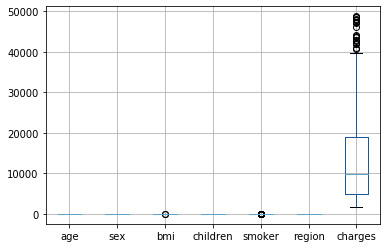

In [ ]:
# creating boxplot

boxlot = df_clean.boxplot()

На этом этапе было замечено, что не все выбросы были учтены для значений charges. Можно было бы произвести повторную очистку всех значений выше 40,000, однако было принято решение этого не делать. Возможно, удастся выявить какие-то интересные закономерности и зависимости для величин в диапазоне от 40,000 до 50,000, в частности, ответить на вопрос, какие признаки влияют на формирование такой высокой суммы выплат.

**6. Нормализация данных.**
Сначала воспользуемся техникой биннинга, а потом попробуем нормализовать столбец charges для повышения наглядности.

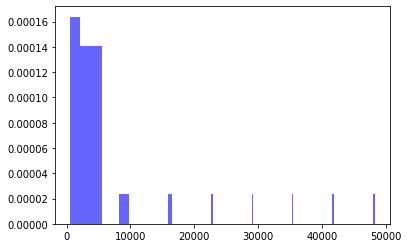

In [ ]:
# visualizing data as histogram

num_bins = 8
plt.hist(df_clean, num_bins, normed=1, facecolor='blue', alpha=0.6, )
plt.show()

In [ ]:
# normalizing data (divide by 1000 to reduce 'charges')

# WARNING when having prediction for 'charges', this number must be multiplied by 1000)

df_norm = df_sorted.copy()
df_norm["charges"] = df["charges"] / 1000
df_norm

age  sex     bmi  children  smoker  region    charges
22    18    1  34.100         0       0       2   1.137011
194   18    1  34.430         0       0       2   1.137470
136   19    1  34.100         0       0       3   1.261442
77    21    1  35.530         0       0       2   1.532470
236   18    0  26.730         0       0       2   1.615767
..   ...  ...     ...       ...     ...     ...        ...
39    60    1  39.900         0       1       3  48.173361
330   61    0  36.385         1       1       0  48.517563
281   54    1  40.565         3       1       0  48.549178
175   63    0  37.700         0       1       3  48.824450
34    28    1  36.400         1       1       3  51.194559

[348 rows x 7 columns]

**7. Проведите анализ набора данных на предмет нечисловых признаков. 
Есть ли в вашем наборе данных категориальные признаки? 
Проведите преобразования, обоснуйте их.**

Нечисловые признаки отсутствуют. Категориальных признаков 3: sex (0,1), smoker (0,1), region (0,1,2,3). Все категориальные признаки уже представлены в числовом виде, преобразовывать не нужно.


**8. Проведите анализ зависимости признаков. 
Для числовых признаков вычислите корреляции друг с другом и с целевой переменной. 
Постройте heatmap. 
Есть ли линейно-зависимые признаки в наборе данных?**

Построена матрица корреляции. Наибольшие коэффициенты корреляции (по Гласс Дж., Стэнли Дж., 1976):
- между age и charges 0.3: меньше 0,5, значит, слабая линейная зависимость;
- между bmi и charges 0.2: меньше 0,5, значит, слабая линейная зависимость;
- между smoker и charges 0.8: сильная линейная зависимость;
- остальные коэффициенты корреляции равны менее 0.2.

Наибольшая корреляция между признаками smoker и charges, равная 0.8. Удалять его не будем, так как эта корреляция не между предикторами, а между предиктором и целевой переменной.
Интересно, что между многими признаками корреляции вообще отсутствует. Например,индекс массы тела никак не связан с полом респондента, а возраст со статусом курильщика. В то же время очень низок КК для признаков region и charges, что может говорить о низкой значимости признака region в отрыве от остальных при формировании суммы выплат charges.

In [ ]:
# calculating correlation

correlation = df_norm.corr()
correlation

age       sex       bmi  children    smoker    region   charges
age       1.000000 -0.078566  0.132440  0.028685 -0.010839 -0.055474  0.317378
sex      -0.078566  1.000000 -0.023251 -0.006161  0.146923 -0.057304  0.098134
bmi       0.132440 -0.023251  1.000000  0.069632  0.018482  0.111163  0.210051
children  0.028685 -0.006161  0.069632  1.000000 -0.002561 -0.045782  0.069593
smoker   -0.010839  0.146923  0.018482 -0.002561  1.000000  0.023023  0.798537
region   -0.055474 -0.057304  0.111163 -0.045782  0.023023  1.000000  0.001551
charges   0.317378  0.098134  0.210051  0.069593  0.798537  0.001551  1.000000

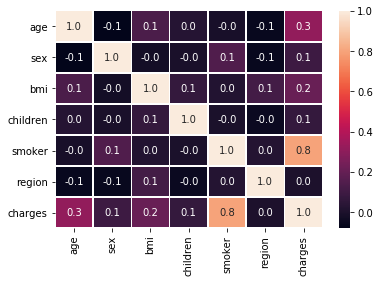

In [ ]:
# making a heatmap for data correlation
	
heatmap = sns.heatmap(correlation, annot=True, fmt=".1f", linewidths=.5)
plt.show()

Интересно теперь построить диграмму рассеивания для данных с наибольшим коэффициентом корреляции.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


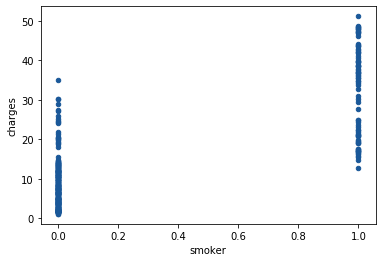

In [ ]:
# creating scatter diagram

scatter = df_norm.plot.scatter('smoker', 'charges')

**9. Визуализируйте ваши данные. 
Постройте графики распределения признаков, проанализируйте их. 
Какую новую информацию о наборе данных даёт визуализация?**

Построены графики распределения для всех признаков. По ним можно заметить:


1.   По признакам sex, region респонденты распределены равномерно (sex:
бимодальное распределение и бинарный признак, region: полимодальное распределение (4 моды), признак принимает 4 значения);
2.   Распределение для age также бимодально, однако это не говорит о равномерности данного признака для всех респондентов: бОльшая их часть в датасете находится в возрасте 18-28 и 55-65 лет, а в возрасте 29-54 года в распределении наблюдается "провал");
3. Для бимодального признака smoker в несколько раз чаще замечено значение 1, чем 0;
4. Распределение для children приближено к правоскошенному (у бОльшей части респондентов нет детей);
5. Распределение для bmi близко к нормально, однако мода немного сдвинута;
6. Распределение для charges правоскошенное со слабовыраженной второй модой.

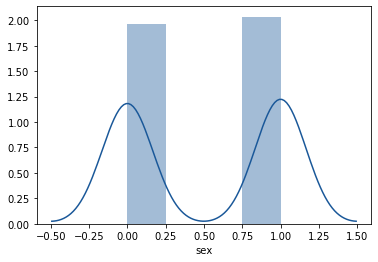

In [ ]:
# making distribution graphics for feature sex

sns.distplot(df_norm.sex)

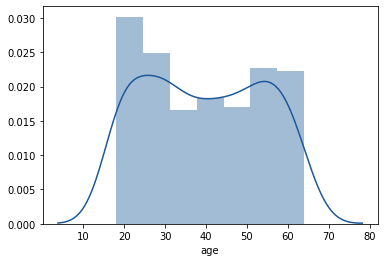

In [ ]:
# making distribution graphics for feature age

sns.distplot(df_norm.age)

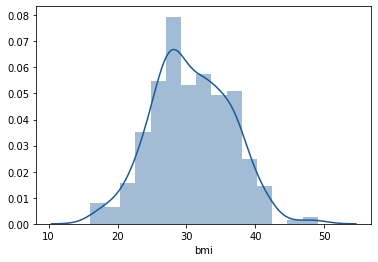

In [ ]:
# making distribution graphics for feature bmi

sns.distplot(df_norm.bmi)

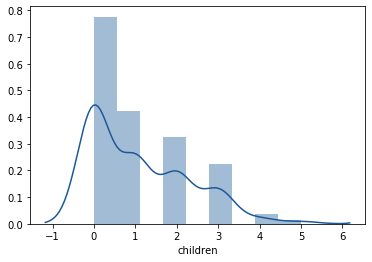

In [ ]:
# making distribution graphics for feature children

sns.distplot(df_norm.children)

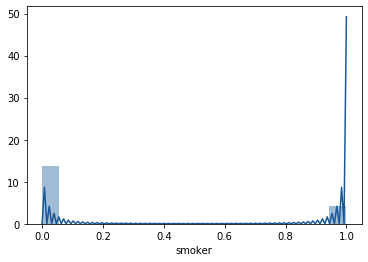

In [ ]:
# making distribution graphics for feature smoker

sns.distplot(df_norm.smoker)

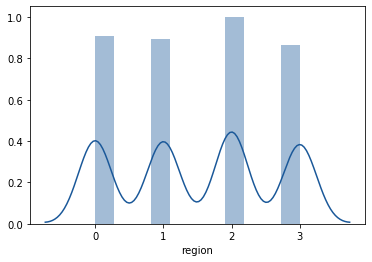

In [ ]:
# making distribution graphics for feature region

sns.distplot(df_norm.region)

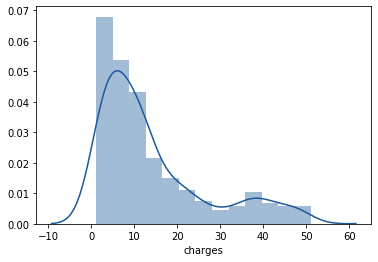

In [ ]:
# making distribution graphics for feature charges

sns.distplot(df_norm.charges)

**10. Сделайте небольшой вывод о вашем первичном исследовании данных.**

Был проанализирован датасет страховых выплат, сделаны следующие выводы.

- Датасет состоит из 7 признаков, все являются численными, при этом три признака являются категориальным.
- С помошью датасета может быть решена задача предсказывания значения charges.
- Все признаки являются значимыми.
- Целевая переменная датасета - charges (сумма страховых выплат).
- Получены стандартные дескриптивные характеристики датасета, по которым можно оценен масштаб и изменчивость данных.
- Датасет имеет выбросы по некоторым признакам. Выбросы были убраны из датасета.
- С помощью матрицы корреляции было выяснено, что в датасете мало коррелирующих величин и есть только одна линейная зависимость.
- В виде гистограммы визуализированы все признаки датасета, исследованы распределения. Датасет признан уравновешенным по признакам sex и region, в распределениях признаков age, smokers, bmi найдены сдвиги.



In [ ]:
ProfileReport(df_norm)

# Подготовка к построению модели

**1. Преобучение**

Сначала перемешаем данные (метод sample). Затем разделим их на тестовую, валидационную и тренировочную коллеции. Посмотрим на распределение целевой переменной для trainset, testset, validation set. Видим по графикам, что распределения близки, значит, можно оставлять такое разделение.

In [ ]:
# shuffling data

df_prepared = df_norm.sample(frac=1) 
df_prepared

age  sex     bmi  children  smoker  region    charges
273   50    1  27.455         1       0       0   9.617662
71    31    1  28.500         5       0       0   6.799458
131   61    0  22.040         0       0       0  13.616359
74    44    1  27.400         2       0       3   7.726854
201   48    0  32.230         1       0       2   8.871152
..   ...  ...     ...       ...     ...     ...        ...
8     37    1  29.830         2       0       0   6.406411
30    22    1  35.600         0       1       3  35.585576
322   34    1  30.800         0       1       3  35.491640
42    41    1  21.780         1       0       2   6.272477
229   47    1  25.460         2       0       0   9.225256

[348 rows x 7 columns]

In [ ]:
y = df_prepared ['charges']
x_all = df_prepared.drop(['charges'], axis=1)

In [ ]:
x_train, x_nottrain, y_train, y_nottrain = train_test_split(x_all, y, test_size=0.4, random_state=412)

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_nottrain, y_nottrain, test_size = 0.1, random_state = 412)

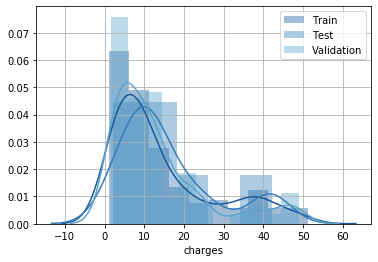

In [ ]:
sns.distplot(y_train, label='Train')
sns.distplot(y_test, label='Test')
sns.distplot(y_val, label ='Validation')

plt.legend()
plt.grid()

plt.show()

In [ ]:
x_train.shape, x_test.shape, x_val.shape

((208, 6), (14, 6), (126, 6))

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((208,), (14,), (126,))

# Построение и обучение множественной линейной регрессии

**1. Обучение**

Обучим модель.

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = model.predict(x_train)

print('R^2:', r2_score(y_train, y_pred))
print('MSE:', mean_squared_error(y_train, y_pred))
print('RMSE:', (mean_squared_error(y_train, y_pred))**1/2)
print('MAE:', mean_absolute_error(y_train, y_pred))
print('Coefs:', model.coef_)

R^2: 0.7568825411426987
MSE: 40.9070893751065
RMSE: 20.45354468755325
MAE: 4.49722568854158
Coefs: [ 0.27158959  0.49541507  0.31845794  0.51882438 24.07358892 -0.02979129]


In [ ]:
y_pred = model.predict(x_val)

print('R^2:', r2_score(y_val, y_pred))
print('MSE:', mean_squared_error(y_val, y_pred))
print('RMSE:', (mean_squared_error(y_val, y_pred))**1/2)
print('MAE:', mean_absolute_error(y_val, y_pred))
print('Coefs:', model.coef_)

R^2: 0.8027969590354176
MSE: 28.521302773600148
RMSE: 14.260651386800074
MAE: 3.89556967047434
Coefs: [ 0.27158959  0.49541507  0.31845794  0.51882438 24.07358892 -0.02979129]


Проинтерпретируем полученные значения. Вместе с относительно небольшими показателями MSE, RMSE, MAE (от 4 до 39), точность получилась средней (0.76-0.80). Поскольку мы стремимся к как можно более высокой точности, можно попробовать другие виды регрессии, то есть усложнить модель.

Но сначала посмотрим, для всех ли данных наша модель дает указанный результат. Воспользуемся методом кросс-валидации.

**2. Кросс-валидация**

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 

for train_index, test_index in kf.split(x_all):
    lr = LinearRegression() 
    lr.fit(np.array(x_all)[train_index], np.array(y)[train_index]) 
    preds = lr.predict(np.array(x_all)[test_index])
 
    print('R^2:', (r2_score(np.array(y)[test_index], preds)))
    print('MSE:', (mean_squared_error(np.array(y)[test_index], preds)))
    print('RMSE:', (mean_squared_error(np.array(y)[test_index], preds))**1/2)
    print('MAE:', (mean_absolute_error(np.array(y)[test_index], preds)))

    print('_' * 20)

R^2: 0.8516181791155008
MSE: 19.764404593788235
RMSE: 9.882202296894118
MAE: 3.1298662453783277
____________________
R^2: 0.6613329636304577
MSE: 50.261888415565814
RMSE: 25.130944207782907
MAE: 4.80041218948346
____________________
R^2: 0.8338679361376529
MSE: 31.624928640739064
RMSE: 15.812464320369532
MAE: 4.03778716197829
____________________
R^2: 0.6969250168483198
MSE: 46.93136020058195
RMSE: 23.465680100290975
MAE: 4.622447178573594
____________________
R^2: 0.7397441845134042
MSE: 42.661361083834194
RMSE: 21.330680541917097
MAE: 4.905664517011534
____________________
R^2: 0.7061421943824613
MSE: 49.308525121562354
RMSE: 24.654262560781177
MAE: 4.708305179683145
____________________
R^2: 0.8090658749538768
MSE: 27.120784044743782
RMSE: 13.560392022371891
MAE: 3.597472979337204
____________________
R^2: 0.8060459952808628
MSE: 28.740576130978052
RMSE: 14.370288065489026
MAE: 4.0085512724299095
____________________
R^2: 0.7449927143474153
MSE: 43.672583496331725
RMSE: 21.836291748

Видим, что R^2 при разном делении данных колеблется от 0,68 до 0,86. Значит, есть стоит проверить: возможно, что модель недообучена.

Поработаем с полиномиальной регрессией.

# Полиномиальная регрессия

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# for poly degree == 2
my_pipe2 = Pipeline([('Poly', PolynomialFeatures(2)), ('Lin_reg', LinearRegression())])
my_pipe2.fit(x_train, y_train)
y_pred2 = my_pipe2.predict(x_val)

In [ ]:
print('Metrics for poly == 2:')
print('R^2:', r2_score(y_val, y_pred2))
print('MSE:', mean_squared_error(y_val, y_pred2))
print('RMSE:', (mean_squared_error(y_val, y_pred2))**1/2)
print('MAE:', mean_absolute_error(y_val, y_pred2))
print('Coefs:', my_pipe2.named_steps.Lin_reg.coef_)

Metrics for poly == 2:
R^2: 0.8543086490085059
MSE: 21.071212253108932
RMSE: 10.535606126554466
MAE: 3.005548805728237
Coefs: [ 1.36977357e+11 -3.30342970e-01  1.13778920e+00  2.08453609e-01
  8.19216091e-01 -1.45311330e+01 -2.16258985e+00  6.85009242e-03
  1.01050158e-01  5.85153225e-04  4.61619534e-03 -3.95117153e-02
  1.51424152e-02  1.13778920e+00 -2.11063227e-01 -2.22039410e-02
  2.44549137e+00 -5.25966879e-01 -3.32106595e-03 -2.79705407e-02
  1.68552091e+00  3.44307324e-03  1.29360100e-01  2.30213030e-01
 -4.98260003e-02 -1.45311330e+01  4.39118655e-01  5.52280521e-01]


In [ ]:
Видим, что на валидационной выборке точность значительно повысилась (достигла 0.85), значения ошибок при этом незначительно снизились. Можно попробовать повысить степень до 3-й.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# for poly degree == 3
my_pipe3 = Pipeline([('Poly', PolynomialFeatures(3)), ('Lin_reg', LinearRegression())])
my_pipe3.fit(x_train, y_train)
y_pred3 = my_pipe3.predict(x_val)

In [ ]:
print('Metrics for poly == 3:')
print('R^2:', r2_score(y_val, y_pred3))
print('MSE:', mean_squared_error(y_val, y_pred3))
print('RMSE:', (mean_squared_error(y_val, y_pred3))**1/2)
print('MAE:', mean_absolute_error(y_val, y_pred3))
print('Coefs:', my_pipe3.named_steps.Lin_reg.coef_)

Metrics for poly == 3:
R^2: 0.6815536039239787
MSE: 46.05662283512762
RMSE: 23.02831141756381
MAE: 4.728050486133044
Coefs: [-4.08502820e+09  4.00760436e-02 -7.75178955e+00  1.97763822e+00
 -3.46530955e+00 -1.72997614e+01 -2.95049264e+00 -3.04953629e-03
  4.13062194e-01 -1.23191867e-02  2.96144235e-01  7.10903331e-01
  9.79537163e-03 -7.75178955e+00  4.88601663e-01  3.39984118e+00
  3.01540236e+00 -2.12325380e+00 -6.31714208e-02  2.10131899e-01
  9.92679797e-01  1.48304721e-01 -9.27060499e-01 -7.34086659e-01
 -2.52535079e+00 -1.72997614e+01 -4.14703145e+00  1.84408184e+00
  2.49929009e-04 -1.75684739e-03 -4.48238947e-04 -5.63590623e-03
 -2.31157622e-02  4.44515577e-04  4.13062194e-01 -1.34933275e-02
 -2.31823929e-01 -7.40582414e-02 -1.10656652e-01  5.71554560e-04
  9.10771215e-03  1.83413593e-04  6.12307294e-03 -1.88016026e-02
  2.62040797e-01 -4.00828773e-02  7.10903331e-01  9.86815171e-02
 -4.87627716e-02 -7.75178955e+00  4.88601663e-01  3.39984118e+00
  3.01540236e+00 -2.12325380e+0

В случае использования полинома 3-й степени на валидацонном сете видим, что метрика R^2 уменьшилась по сравнению со случаем, когда полиномиальна регрессия имела максимальную степень 2. Значения метрик ошибок заметно увеличились. Делаем вывод, что из трех построенных моделей без применения регуляризации наилучшей будет вторая, где используется полином второй степени.

# Регуляризация

Посколькку ошибки все еще большие и коэффициенты тоже выглядят внушающе, воспользуемся методами L2- и L1-регуляризации, а также ElasticNet-регрессией.

**1. L2-регуляризация**

In [ ]:
reg2 = Ridge()
reg2.fit(x_train, y_train)

y_pred = reg2.predict(x_val)

print('R^2:', r2_score(y_val, y_pred))
print('MSE:', mean_squared_error(y_val, y_pred))
print('RMSE:', (mean_squared_error(y_val, y_pred))**1/2)
print('MAE:', mean_absolute_error(y_val, y_pred))
print('Coefs:', reg2.coef_)

R^2: 0.8029772078655913
MSE: 28.49523354345629
RMSE: 14.247616771728145
MAE: 3.9756333157821175
Coefs: [ 2.70927315e-01  5.68431219e-01  3.21653382e-01  5.11155757e-01
  2.34365448e+01 -1.73148399e-02]


Видим, что уменьшились значения коэффициентов по сравнению с моделью множественной регрессии, но значения ошибок не слишком снизились. Снизилось значение R^2.

Теперь L1-регуляризация. Посмотрим, какие она даст результаты (особенно важно, какие коэффициенты занулятся).

**2. L1-регуляризация**

In [ ]:
from sklearn.linear_model import Ridge, Lasso

from sklearn import linear_model
reg = linear_model.Lasso (alpha=0.1)
reg.fit(x_train, y_train)

y_pred = reg.predict(x_val)

print('R^2:', r2_score(y_val, y_pred))
print('MSE:', mean_squared_error(y_val, y_pred))
print('RMSE:', (mean_squared_error(y_val, y_pred))**1/2)
print('MAE:', mean_absolute_error(y_val, y_pred))
print('Coefs:', reg.coef_)

R^2: 0.803567441605868
MSE: 28.409868555516525
RMSE: 14.204934277758262
MAE: 3.9553471189225795
Coefs: [ 0.26943009  0.15007067  0.32151154  0.44163071 23.57362111 -0.        ]


L1-регуляризация занулила один коэффициент (менее значимый) и немного уменьшила значения оставшихся. Ошибка осталась такой же, как и при использовании модели с полиномом второй степени.

Посмотрим на ElasticNet-регрессию.

**3. ElasticNet**

In [ ]:
reg3 = linear_model.ElasticNet()
reg3.fit(x_train, y_train)

y_pred = reg3.predict(x_val)

print('R^2:', r2_score(y_val, y_pred))
print('MSE:', mean_squared_error(y_val, y_pred))
print('RMSE:', (mean_squared_error(y_val, y_pred))**1/2)
print('MAE:', mean_absolute_error(y_val, y_pred))
print('Coefs:', reg3.coef_)

R^2: 0.40558902013701503
MSE: 85.96913843569659
RMSE: 42.984569217848296
MAE: 7.708255047357587
Coefs: [0.239982   0.26869471 0.41651545 0.         5.66891837 0.        ]


Хотя ElasticNet занулила уже 2 коэффициента, она все же показывает более низкую точность и более высокую ошибку (почти в 2 раза) по сравнению со всеми прошлыми моделями.

# Выводы

Таким образом, по результатам тестов на валидационных выборках, наилучшей можно считать модель полиномиальной регрессии второй степени. Оценим ее работу на тестовой выборке.

In [ ]:
y_test.shape, y_pred2.shape

((14,), (126,))

In [ ]:
# the name of y in our model is "y_pred2"
# also change y_train by y_test

my_pipe2 = Pipeline([('Poly', PolynomialFeatures(2)), ('Lin_reg', LinearRegression())])
my_pipe2.fit(x_train, y_train)
y_pred2 = my_pipe2.predict(x_test)

print('R^2:', r2_score(y_test, y_pred2))
print('MSE:', mean_squared_error(y_test, y_pred2))
print('RMSE:', (mean_squared_error(y_test, y_pred2))**1/2)
print('MAE:', mean_absolute_error(y_test, y_pred2))
print('Coefs:', my_pipe2.named_steps.Lin_reg.coef_)

R^2: 0.7803746108702093
MSE: 32.148229352302714
RMSE: 16.074114676151357
MAE: 4.017838274907925
Coefs: [ 1.36977357e+11 -3.30342970e-01  1.13778920e+00  2.08453609e-01
  8.19216091e-01 -1.45311330e+01 -2.16258985e+00  6.85009242e-03
  1.01050158e-01  5.85153225e-04  4.61619534e-03 -3.95117153e-02
  1.51424152e-02  1.13778920e+00 -2.11063227e-01 -2.22039410e-02
  2.44549137e+00 -5.25966879e-01 -3.32106595e-03 -2.79705407e-02
  1.68552091e+00  3.44307324e-03  1.29360100e-01  2.30213030e-01
 -4.98260003e-02 -1.45311330e+01  4.39118655e-01  5.52280521e-01]


**Оценка**

*   R^2: 0.78 (точность на тестовой выборке незначительно снизилась* по сравнению с валидационной);
*   MSE: 32.1 (не самое низкое значение среди всех моделей на валидационных выборках, MSE ниже у L1-регрессии на валидационной выборке);
*   RMSE: 16.1 (значение RMSE ниже только у множественной регрессии);
*   MAE: 4.0 (значение MAE ниже только у L1-, L2-регрессий).

*небольшие колебания значений можно объяснить неидеальным совпадением распределений для тренировочной, валидационной и тестовой выборок



**Коэффициенты**

Коэффициенты получились достаточно маленькими (нет риск переобучения), ни один из них не занулился, поскольку не была использована регуляризация.

**Идеи**

В будущем стоит лучше проработать вопрос деления на train-test-validation, поскольку от этого во многом зависят колебания величин ошибок.

Также стоит учиться активнее использовать кросс-валидацию.